In [2]:
from cmcd.densities import Funnel, GaussianMixture
import matplotlib.pyplot as plt 
import numpy as np
import torch


In [1]:
# Seaborn setup 
sns.set_style('white')

NameError: name 'sns' is not defined

In [1]:
import torch
from cmcd.replay_buffer import ReplayBuffer

INFO:2024-01-19 02:09:10 170702:170702 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti


In [18]:
buffer = ReplayBuffer(2, 2, 5)

prio = torch.tensor([1.0, 2.0, 3.0])
paths = torch.tensor([[[1.0, 2.0], [5.0, 2.0]], [[1.0, 3.0], [1.0, 4.0]], [[3.0, 2.0], [1.0, 22.0]]])
buffer.add(prio, paths)
buffer.add(prio, paths)
buffer.add(prio, paths)

print(buffer.size())
print(buffer.paths, buffer.prio)

print(buffer.sample(4))


5
tensor([[[ 1.,  3.],
         [ 1.,  4.]],

        [[ 3.,  2.],
         [ 1., 22.]],

        [[ 1.,  2.],
         [ 5.,  2.]],

        [[ 1.,  3.],
         [ 1.,  4.]],

        [[ 3.,  2.],
         [ 1., 22.]]]) tensor([2., 3., 1., 2., 3.])
tensor([[[ 3.,  2.],
         [ 1., 22.]],

        [[ 3.,  2.],
         [ 1., 22.]],

        [[ 1.,  3.],
         [ 1.,  4.]],

        [[ 1.,  3.],
         [ 1.,  4.]]])


In [5]:
from cmcd.sampler import CMCD
from cmcd.score import ResNet
from cmcd.densities import GaussianMixture, DoubleWell
from cmcd.anneal import GeometricAnnealing

import torch 
import torch.nn as nn 
from torch.distributions import MultivariateNormal
from cmcd.initial_dist import GaussianVI

from cmcd.densities import Funnel, GaussianMixture
from cmcd.loss_fn import TrajectoryBalance
import matplotlib.pyplot as plt 
import numpy as np
import torch


In [4]:
subtraj = dict(
    ln_w=[torch.tensor([0.6, 0.4], requires_grad=True), torch.tensor([2.0, 2.3], requires_grad=True)],
    ln_phi=[torch.tensor([1.0, 3.0], requires_grad=True), torch.tensor([2.0, 1.0], requires_grad=True), torch.tensor([3.0, 2.0], requires_grad=True)]
)

batch = int(x.shape[0] * a)
repel_x = x[:batch]
distance_m = torch.cdist(repel_x, repel_x)
h_t = distance_m.flatten().median() ** 2 / torch.tensor(batch).log()
d = (-(distance_m**2 / h_t)).exp()
f = repel_x[:, None] - repel_x[None, :]
force = -0.1 * (d[:, :, None] * f).sum(1) / h_t

return torch.nn.functional.pad(
    force, (0, 0, 0, x.shape[0] - batch), "constant", 0
)

In [2]:
dw = DoubleWell(50, 5, 4)
dw.log_norm()

tensor(40.7620, device='cuda:0')

In [15]:
x = torch.tensor([[1.5, 1.5], [2.0, 2.0], [2.5, 2.6], [2.5, 1.0], [2.5, 0.9], [2.5, 3.0]])

a = 0.5
batch = int(x.shape[0] * a)
repel_x = x[:batch]
distance_m = torch.cdist(repel_x, repel_x)
h_t = distance_m.flatten().median() ** 2 / torch.tensor(batch).log()
d = (-(distance_m**2 / h_t)).exp()
f = repel_x[:, None] - repel_x[None, :]
force = -0.1 * (d[:, :, None] * f).sum(1) / h_t

print(d)
print((repel_x[:, None] - repel_x[None, :]) )

print(d[:, :, None] * (repel_x[:, None] - repel_x[None, :]) )

-torch.nn.functional.pad(
    force, (0, 0, 0, x.shape[0] - batch), "constant", 0
)

tensor([[1.0000, 0.3333, 0.0078],
        [0.3333, 1.0000, 0.2618],
        [0.0078, 0.2618, 1.0000]])
tensor([[[ 0.0000,  0.0000],
         [-0.5000, -0.5000],
         [-1.0000, -1.1000]],

        [[ 0.5000,  0.5000],
         [ 0.0000,  0.0000],
         [-0.5000, -0.6000]],

        [[ 1.0000,  1.1000],
         [ 0.5000,  0.6000],
         [ 0.0000,  0.0000]]])
tensor([[[ 0.0000,  0.0000],
         [-0.1667, -0.1667],
         [-0.0078, -0.0086]],

        [[ 0.1667,  0.1667],
         [ 0.0000,  0.0000],
         [-0.1309, -0.1571]],

        [[ 0.0078,  0.0086],
         [ 0.1309,  0.1571],
         [ 0.0000,  0.0000]]])


tensor([[-0.0383, -0.0385],
        [ 0.0079,  0.0021],
        [ 0.0305,  0.0364],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000]])

In [2]:

score_fn = ResNet(5, 36, 41, 32).cuda()

initial_dist = GaussianVI(5, 3.0).cuda()

target = DoubleWell(5, 5, 4)

anneal = GeometricAnnealing()

sampler = CMCD(initial_dist, target, anneal, score_fn, 32, 0.01).to('cuda')

optim = torch.optim.Adam(sampler.parameters(), lr=1e-1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=100)

tensor(-0.6465, device='cuda:0', grad_fn=<SubBackward0>) tensor(108.3787, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5400, device='cuda:0')


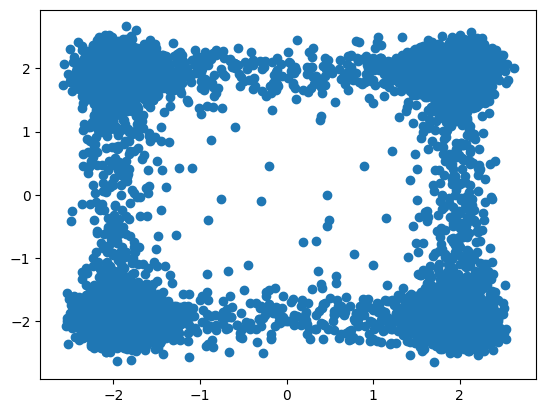

In [3]:
samples = sampler.sample(10000, loss_fn="mean", correct=False, repel=False, a=1.0)

print(samples.ln_z, samples.loss)
print(target.log_norm())

plt.scatter(samples.particles[:, 0].detach().cpu().numpy(), samples.particles[:, 1].detach().cpu().numpy())

In [4]:
samples = sampler.sample(10000, loss_fn="var", correct=False, repel=True, a=1.0)


print(samples.ln_z, samples.loss)
print(target.log_norm())

plt.scatter(samples.particles[:, 0].detach().cpu().numpy(), samples.particles[:, 1].detach().cpu().numpy())

KeyboardInterrupt: 

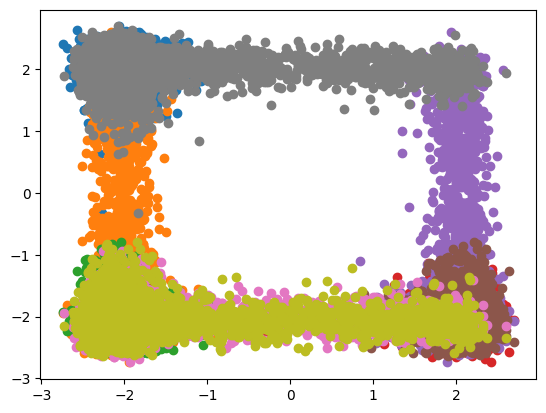

In [6]:
for i in range(3):
    for j in range(4):
        if i != j:
            plt.scatter(samples.particles[:, i].detach().cpu().numpy(), samples.particles[:, j].detach().cpu().numpy())

In [43]:
(sampler.repel(samples.particles)) * 0.01

tensor([[ 21.1661, -11.2077],
        [-34.0363,  28.3828],
        [ 34.9589,  31.2083],
        ...,
        [ 26.7869, -31.1697],
        [ 33.1269,  28.0406],
        [ -6.3147,  12.2653]], device='cuda:0')

In [16]:

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-20, 20, 30)
y = np.linspace(-20, 20, 30)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

# %timeit sampler.drift(coords, 4).cpu().detach()
%timeit sampler.log_phi(coords, 6 / 8)



679 µs ± 135 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
sampler.score_fn

ResNet(
  (embed_timestep): Embedding(9, 38)
  (fc1): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
  (fc2): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
  (fc3): Linear(in_features=40, out_features=1, bias=False)
)

In [15]:


import torch._dynamo
torch._dynamo.config.suppress_errors = True

import numpy as np
import matplotlib.pyplot as plt

b = 10
s = 50
x = np.linspace(-b, b, s)
y = np.linspace(-b, b, s)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()


# gg = (sampler.score_fn(coords, 4) * 10 ** 14 *  torch.nn.functional.normalize(sampler.grad_log_phi_(coords, 6, True), dim=1)).cpu().detach()
gg = (sampler.drift(coords, 16)).cpu().detach()
gg = (-sampler.score_fn(coords, 20)).cpu().detach()


mag = torch.norm(gg, dim=1).reshape(s, s)

print(torch.norm(gg, dim=1).mean())
plt.figure(figsize=(10, 10))

plt.quiver(X, Y, gg[:, 0], gg[:, 1])
plt.contour(X, Y, mag)
plt.colorbar()

print(sampler.score_fn.scale)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2500x2 and 5x40)

In [28]:
x = torch.tensor([[1.0, 1.0], [2.0, 5.0], [4.0, 4.0]])

In [31]:
f = - 2 * (x[:, None] - x[None, :]).sum(1)
f

tensor([[  8.,  14.],
        [  2., -10.],
        [-10.,  -4.]])

In [35]:
d = (-(torch.cdist(x, x) ** 2)).exp().sum(1)
d

tensor([1.0000, 1.0067, 1.0067])

In [37]:
f * d[:, None]

tensor([[  8.0000,  14.0000],
        [  2.0135, -10.0674],
        [-10.0674,  -4.0270]])

: 

In [6]:
sampler.eps
sampler.betas()

tensor([0.0000, 0.1133, 0.2282, 0.3447, 0.4668, 0.6014, 0.7346, 0.8672, 1.0000],
       device='cuda:0', grad_fn=<DivBackward0>)

In [36]:
sampler.repel(samples.particles)

tensor([[-104.2496, -159.6876,  -80.5175,  138.0436,  144.3194],
        [ 476.0269, -313.0292,  -95.3671,   50.6934,   90.2740],
        [  96.1687,  -60.1733,  102.4588,  -53.8138,   88.1990],
        ...,
        [-581.6094,   49.6249,  174.5681,  101.2871, -179.0338],
        [  69.7600,  -13.3155,   60.1516,  -75.2948,   69.3456],
        [-196.7796,  126.5544, -155.2065, -140.9308,  199.4352]],
       device='cuda:0')

In [7]:
for i in range(10000):
    optim.zero_grad()
    samples = sampler.sample(3000, loss_fn="var", correct=False, repel=True, a=0.5)
    loss = samples.loss
    assert loss != None
    # if i % 20 == 0:
    loss.backward()
    # print(sampler.score_fn.scale)
    print(loss.item(), sampler.score_fn.scale.item(), samples.ln_z.item())
    # print(loss, samples.ln_z.item(), samples.elbo.item(), samples2.ln_z.item(), samples2.elbo.item())
    optim.step()
    scheduler.step()
    

863.7626953125 0.6763034462928772 -21.531513214111328
737.47705078125 0.6778823733329773 -8.125012397766113
681.7000122070312 0.677582859992981 -15.956802368164062
737.6953125 0.6754868626594543 -19.994365692138672
634.1867065429688 0.672622561454773 -6.399284362792969
686.1063232421875 0.6683309078216553 3.6713638305664062
695.5575561523438 0.662674069404602 2.135220527648926
661.6764526367188 0.6564545035362244 4.940072059631348
681.3248291015625 0.6494894027709961 5.675118446350098
718.325439453125 0.6424437165260315 10.876294136047363
630.697998046875 0.6353476047515869 5.090198516845703
694.0678100585938 0.6283784508705139 4.535120010375977
751.8439331054688 0.6219859719276428 -0.21898603439331055
698.22802734375 0.6165910363197327 3.4197778701782227
670.2063598632812 0.612275242805481 -6.064133167266846
667.8906860351562 0.609199583530426 -13.87520694732666
624.8118286132812 0.6072270274162292 -4.999173641204834
564.968017578125 0.6063967347145081 -19.040809631347656
508.02050781

KeyboardInterrupt: 

In [49]:
sampler.sample((500,), correct=False).ln_z

AUTOTUNE addmm(500x40, 500x40, 40x40)
  bias_addmm 0.0082 ms 100.0%
  addmm 0.0105 ms 78.3%
SingleProcess AUTOTUNE takes 0.2354 seconds
AUTOTUNE addmm(500x2, 500x40, 40x2)
  bias_addmm 0.0067 ms 100.0%
  addmm 0.0092 ms 72.6%
SingleProcess AUTOTUNE takes 0.2188 seconds
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING]    function: 'resume_in_step' (/home/brianlck/code/code/dissertation/mcmd/sampler.py:165)
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING]    last reason: ___check_obj_id(L['correct'], 94027720832032)
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2023-12-10 03:06:11,624] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/troubleshooting.html.


tensor(-0.0200, device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
import torch.autograd.profiler as profiler

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    samples = sampler.sample(10)

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=100))

In [118]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-50, 50, 10)
y = np.linspace(-50, 50, 10)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

score = -score_fn(coords, 2).detach().cpu()
mag = torch.norm(score, dim=1).reshape(10, 10)

plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.contour(X, Y, mag)
plt.colorbar()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x37 and 40x40)

In [5]:

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32)

score = sampler.grad_log_phi(coords, 6 / 8).detach()
mag = torch.norm(score, dim=1).reshape(100, 100)

score = score / mag.reshape(-1, 1)

densities = dw.log_density(coords).reshape(100, 100).exp()

plt.figure(figsize=(20, 20))
plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.colorbar()

NameError: name 'np' is not defined

In [7]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32)


score = torch.func.jacrev(lambda x: target.log_density(x).mean())(coords).detach()
mag = torch.norm(score, dim=1).reshape(100, 100)

densities = target.log_density(coords).reshape(100, 100).exp()

score = score / mag.reshape(-1, 1)

plt.figure(figsize=(20, 20))

plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.contour(X, Y, densities)
plt.colorbar()

NameError: name 'target' is not defined

tensor(-0.0296)
0.0


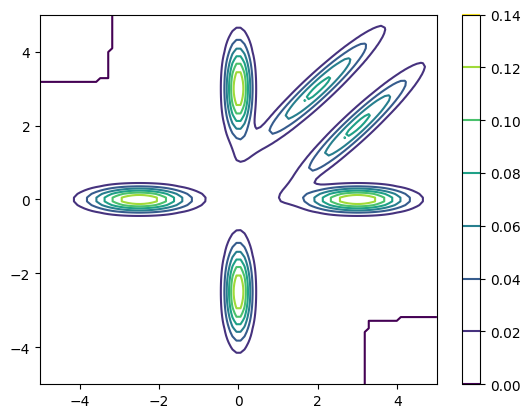

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cmcd.densities import GaussianMixture
import torch


gmm = GaussianMixture()


n = 100
b = 5
x = np.linspace(-b, b, n)
y = np.linspace(-b, b, n)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords)

density = gmm.log_density(coords).reshape(n, n).T.exp().cpu()

cum = (density.sum() * (2 * b / n) * (2 * b / n)).log()

print(cum)
print(gmm.log_norm())

plt.contour(X, Y, density)
plt.colorbar()

In [7]:
DoubleWell(5, 5, 4).log_norm()


tensor(-0.5424, device='cuda:0')

In [3]:
import torch
dw.log_density(torch.tensor([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]))

tensor([1.2664e-14, 1.2664e-14, 1.2664e-14, 1.2664e-14, 1.2664e-14, 1.2664e-14,
        1.2664e-14])

In [ ]:
score_fn(coords[:2], 1)

In [ ]:
score_fn(coords[:2], 2)